In [ ]:
import sys
import os
import pickle
import random
from typing import Dict

import numpy as np
import pandas as pd
from tqdm import tqdm


# Bio libraries
from Bio import Entrez, SeqIO

# Scikit-learn
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import GroupShuffleSplit,train_test_split

# ML frameworks
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


# System utilities
import gc


# Local imports
sys.path.insert(0, '..')
from src.cache import load_cache
from src.data_management import get_gff_path
from src.config import TEST_GENOMES, FIRST_FILTER_THRESHOLD, START_SELECTION_WEIGHTS
from src.traditional_methods import (
    find_orfs_candidates,
    create_training_set,
    create_intergenic_set,
    build_all_scoring_models,
    score_all_orfs,
    filter_candidates,
    organize_nested_orfs,
    select_best_starts
)
from src.comparative_analysis import compare_orfs_to_reference

print("✓ All imports successful")

✓ All imports successful


In [2]:
# Set your email for NCBI
Entrez.email = "your_email@example.com"

# Taxonomic groups for querying random genomes
GROUP_TAXIDS = {
    "Proteobacteria": 1224,
    "Firmicutes": 1239,
    "Actinobacteria": 201174,
    "Archaea": 2157,
}

# Curated training genome list
TRAINING_GENOMES = [
    # Gram-negative
    'NC_011751.1', 'NC_017626.1', 'NC_009004.1', 'NC_007912.1',
    'NC_002946.2', 'NC_004547.2', 'NC_007005.1', 'NC_009656.1',
    # Gram-positive
    'NC_014479.1', 'NC_020244.1', 'NC_003212.1', 'NC_002570.2',
    'NC_007795.1', 'NC_004461.1', 'NC_002737.2',
    # Actinobacteria
    'NC_008595.1', 'NC_002755.2', 'NC_009338.1', 'NC_014363.1',
    # High GC
    'NC_003888.3', 'NC_009921.1', 'NC_008148.1',
    # Archaea
    'NC_013967.1', 'NC_015666.1', 'NC_007796.1', 'NC_013790.1', 'NC_000909.1',
]

print(f"✓ Configuration loaded")
print(f"  - Training genomes: {len(TRAINING_GENOMES)}")
print(f"  - Taxonomic groups: {len(GROUP_TAXIDS)}")


✓ Configuration loaded
  - Training genomes: 27
  - Taxonomic groups: 4


In [3]:

raw_cache_file = "all_orfs_cache.pkl"
final_cache_file = "nested_groups_cache.pkl"

if os.path.exists(final_cache_file):
        with open(final_cache_file, "rb") as f:
            final_cache = pickle.load(f)

In [4]:
# CELL 3: NCBI GENOME QUERY FUNCTIONS

def get_random_genomes_nuccore(taxid, n=5):
    """
    Fetch random genome accessions for a given taxid using the NCBI nuccore database.
    Includes both chromosomes and complete plasmids.
    
    MEMORY SAFE: Only returns metadata, not sequences.
    """
    query = f"txid{taxid}[Organism:exp] AND complete genome[Title]"
    handle = Entrez.esearch(db="nuccore", term=query, retmax=500)
    result = Entrez.read(handle)
    handle.close()  # IMPORTANT: Always close handles

    ids = result.get("IdList", [])
    if not ids:
        # fallback: just search for 'genome' keyword if no complete genomes
        query = f"txid{taxid}[Organism:exp] AND genome[Title]"
        handle = Entrez.esearch(db="nuccore", term=query, retmax=500)
        result = Entrez.read(handle)
        handle.close()
        ids = result.get("IdList", [])

    if not ids:
        return []

    random.shuffle(ids)
    chosen = ids[:n]

    # Fetch summaries to get accessions and organism names
    handle = Entrez.esummary(db="nuccore", id=",".join(chosen))
    records = Entrez.read(handle)
    handle.close()

    summaries = []
    for rec in records:
        summaries.append({
            "accession": rec["AccessionVersion"],
            "organism": rec["Title"],
        })

    return summaries

print("✓ NCBI query functions defined")

✓ NCBI query functions defined


In [5]:

# CELL 4: GENOME DOWNLOAD FUNCTIONS

def download_genome_fasta(genome_id):
    """
    Download genome FASTA from NCBI.
    
    MEMORY SAFE: Returns string, handle is closed properly.
    """
    handle = Entrez.efetch(db="nucleotide", id=genome_id, rettype="fasta", retmode="text")
    record = SeqIO.read(handle, "fasta")
    handle.close()  # IMPORTANT: Close handle to prevent memory leak
    return str(record.seq)


def download_genome_gff(genome_id):
    """
    Download genome GFF from NCBI.
    
    MEMORY SAFE: Only stores gene coordinates, not full GFF.
    """
    handle = Entrez.efetch(db="nucleotide", id=genome_id, rettype="gff", retmode="text")
    lines = handle.read().splitlines()
    handle.close()  # IMPORTANT: Close handle
    
    genes = []
    for line in lines:
        if line.startswith("#"):
            continue
        parts = line.split("\t")
        if len(parts) < 9:
            continue
        if parts[2] != "gene":
            continue
        start, end, strand = int(parts[3])-1, int(parts[4]), parts[6]
        genes.append({"start": start, "end": end, "strand": strand})
    
    # MEMORY LEAK FIX: Clear lines after processing
    del lines
    
    return genes

print("✓ Genome download functions defined")


✓ Genome download functions defined


In [6]:
# CELL 6: GENOME PROCESSING PIPELINE


def process_and_cache_genome(genome_id):
    """
    Complete pipeline to download, process, and cache a genome with ORF analysis.
    Returns final cache with nested groups and reference starts.
    
    MEMORY LEAK FIXES:
    - Deletes temporary cache file after use
    - Clears intermediate variables
    - Returns only final cache
    """
    print(f"Processing {genome_id}...")
    
    # Download raw genome data
    sequence = download_genome_fasta(genome_id)
    reference_genes = download_genome_gff(genome_id)

    # Save temporary cache
    temp_cache = {
        "sequence": sequence,
        "reference_genes": reference_genes
    }
    temp_file = f"temp_{genome_id}.pkl"
    with open(temp_file, "wb") as f:
        pickle.dump(temp_cache, f)

    # Compute all ORFs
    all_orfs = find_orfs_candidates(sequence)

    # Create training and intergenic sets
    training_set = create_training_set(sequence, reference_genes, all_orfs)
    intergenic_set = create_intergenic_set(sequence, reference_genes, all_orfs)

    # Build scoring models
    models = build_all_scoring_models(training_set, intergenic_set)

    # Score and filter ORFs
    scored_orfs = score_all_orfs(all_orfs, models)
    candidates = filter_candidates(scored_orfs, **FIRST_FILTER_THRESHOLD)

    # Organize nested groups
    grouped_orfs = organize_nested_orfs(candidates)

    # MEMORY LEAK FIX: Clear large intermediate objects
    del all_orfs, training_set, intergenic_set, models, scored_orfs, candidates
    gc.collect()

    # Save final cache
    final_cache = {
        "nested_groups": grouped_orfs,
        "reference_starts": {orf['id']: orf['start'] for orf in reference_genes}
    }
    
    final_file = f"cached_{genome_id}_groups.pkl"
    with open(final_file, "wb") as f:
        pickle.dump(final_cache, f)

    # MEMORY LEAK FIX: Clean up temporary files and variables
    if os.path.exists(temp_file):
        os.remove(temp_file)
    del temp_cache, sequence, reference_genes, grouped_orfs
    gc.collect()
    
    print(f"✓ Completed {genome_id}")
    return final_cache


def cache_all_orfs(training_genomes, raw_cache_file="all_orfs_cache.pkl"):
    """
    Download genomes and compute all ORFs, saving them in a raw cache.
    
    MEMORY LEAK FIXES:
    - Saves incrementally to prevent memory buildup
    - Clears genome data after processing
    - Explicit garbage collection
    """
    if os.path.exists(raw_cache_file):
        with open(raw_cache_file, "rb") as f:
            all_orfs = pickle.load(f)
        print(f"Loaded existing raw cache with {len(all_orfs)} genomes.")
    else:
        all_orfs = {}

    for genome_id in training_genomes:
        if genome_id in all_orfs:
            print(f"{genome_id} already cached, skipping...")
            continue

        try:
            # Process genome
            final_cache = process_and_cache_genome(genome_id)
            all_orfs[genome_id] = final_cache
            
            # MEMORY LEAK FIX: Save incrementally and clear
            with open(raw_cache_file, "wb") as f:
                pickle.dump(all_orfs, f)
            
            del final_cache
            gc.collect()
            
        except Exception as e:
            print(f"Error processing {genome_id}: {e}")
            continue

    print(f"\n✓ Cached {len(all_orfs)} genomes")
    return all_orfs


def rename_all_orfs_to_orfs(raw_cache_file="all_orfs_cache.pkl"):
    """
    Rename the 'all_orfs' key to 'orfs' for all genomes in the raw cache.
    
    MEMORY SAFE: Works in-place on cache file.
    """
    if not os.path.exists(raw_cache_file):
        raise FileNotFoundError(f"{raw_cache_file} not found.")

    with open(raw_cache_file, "rb") as f:
        all_orfs = pickle.load(f)

    for genome_id, data in all_orfs.items():
        if "all_orfs" in data:
            data["orfs"] = data.pop("all_orfs")  # rename key
            print(f"Renamed 'all_orfs' to 'orfs' for genome {genome_id}")

    with open(raw_cache_file, "wb") as f:
        pickle.dump(all_orfs, f)
    
    print(f"✓ All genomes updated in {raw_cache_file}")
    
    # MEMORY LEAK FIX: Clear cache from memory
    del all_orfs
    gc.collect()
    
    return True


def process_genome_from_raw_cache(genome_id, raw_cache_file="all_orfs_cache.pkl", 
                                   final_cache_file="nested_groups_cache.pkl"):
    """
    Take a genome from raw ORFs cache, run all scoring/filtering/grouping,
    save to final cache with reference starts, and remove from raw cache.
    
    MEMORY LEAK FIXES:
    - Clears intermediate objects explicitly
    - Removes genome from raw cache after processing
    - Forces garbage collection
    """
    # Load raw ORFs cache
    if not os.path.exists(raw_cache_file):
        raise FileNotFoundError(f"{raw_cache_file} not found.")
    
    with open(raw_cache_file, "rb") as f:
        all_orfs = pickle.load(f)

    if genome_id not in all_orfs:
        raise ValueError(f"{genome_id} not in raw ORFs cache.")

    data = all_orfs[genome_id]
    sequence = data["sequence"]
    reference_genes = data["reference_genes"]
    orfs = data["orfs"]

    print(f"Processing {genome_id}...")
    
    # Create training/intergenic sets
    print("  Creating training/intergenic sets...")
    training_set = create_training_set(sequence, reference_genes, orfs)
    intergenic_set = create_intergenic_set(sequence, reference_genes, orfs)

    # Build models, score ORFs, filter, group
    print("  Building models and scoring...")
    models = build_all_scoring_models(training_set, intergenic_set)
    scored_orfs = score_all_orfs(orfs, models)
    candidates = filter_candidates(scored_orfs, **FIRST_FILTER_THRESHOLD)
    
    print("  Organizing nested ORFs...")
    grouped_orfs = organize_nested_orfs(candidates)

    # MEMORY LEAK FIX: Clear intermediate objects
    del training_set, intergenic_set, models, scored_orfs, candidates
    gc.collect()

    # Keep only groups with >1 ORF
    filtered_groups = {g_id: group for g_id, group in grouped_orfs.items() if len(group) > 1}
    del grouped_orfs
    gc.collect()

    # Load final cache if exists
    if os.path.exists(final_cache_file):
        with open(final_cache_file, "rb") as f:
            final_cache = pickle.load(f)
        nested_groups = final_cache.get("nested_groups", {})
        reference_starts = final_cache.get("reference_starts", {})
    else:
        nested_groups = {}
        reference_starts = {}

    # Save genome to final cache
    nested_groups[genome_id] = filtered_groups
    reference_starts[genome_id] = {orf['id']: orf['start'] for orf in reference_genes}

    final_cache = {
        "nested_groups": nested_groups,
        "reference_starts": reference_starts
    }

    with open(final_cache_file, "wb") as f:
        pickle.dump(final_cache, f)
    
    print(f"✓ {genome_id} processed and saved to final cache. Groups >1 ORF: {len(filtered_groups)}")

    # MEMORY LEAK FIX: Remove genome from raw cache to save space
    del all_orfs[genome_id]
    with open(raw_cache_file, "wb") as f:
        pickle.dump(all_orfs, f)
    
    print(f"✓ {genome_id} removed from raw ORFs cache.")

    # MEMORY LEAK FIX: Clear all local references
    del all_orfs, data, sequence, reference_genes, orfs, filtered_groups
    del nested_groups, reference_starts
    gc.collect()

    return final_cache

print("✓ Genome processing pipeline defined")

✓ Genome processing pipeline defined


In [ ]:
def entropy_from_probs(arr, base=2):
    """Compute entropy (bits by default) for a 1D array of non-negative numbers (will normalize)."""
    arr = np.asarray(arr, dtype=float)
    if arr.size == 0:
        return 0.0
    s = arr.sum()
    if s <= 0:
        return 0.0
    p = arr / s
    p = p[p > 0]
    return -np.sum(p * np.log(p) / np.log(base))

def prepare_group_level_dataframe(groups, genome_id, cached_data=None, weights=None):
    """
    Create a group-level feature DataFrame for ML, including start_selection_score and comparative features.
    Each row corresponds to one group.
    - Label = 1 if any ORF in the group overlaps a CDS, else 0.
    - Features = aggregated ORF scores, start-selection, comparative statistics.

    Args:
        groups: dict[group_id -> list of ORF dicts]
        genome_id: genome identifier (used to read reference CDS)
        cached_data: optional (not needed here, kept for interface)
        weights: optional dict of start-selection weights

    Returns:
        DataFrame: one row per group, columns = features + label
    """
    # Load reference CDS positions
    gff_path = get_gff_path(genome_id)
    ref = pd.read_csv(gff_path, sep="\t", comment="#", header=None)
    ref = ref[ref[2] == "CDS"][[3, 4, 6]]  # start, end, strand
    ref.columns = ["start", "end", "strand"]
    ref = ref.drop_duplicates()
    ref_tuples = set(zip(ref["start"], ref["end"], ref["strand"]))

    rows = []
    for group_id, orf_list in tqdm(groups.items(), total=len(groups), desc=f"Groups {genome_id}"):
        if len(orf_list) == 0:
            continue

        combined_scores = []
        rbs_scores = []
        codon_scores = []
        start_scores = []
        imm_scores = []
        start_select_scores = []
        strands = []
        label = 0

        for orf in orf_list:
            start = orf.get("genome_start") or orf.get("start")
            end = orf.get("genome_end") or orf.get("end")
            strand = orf.get("strand", "+")
            if isinstance(strand, str):
                if strand.lower().startswith("forw"): strand = "+"
                elif strand.lower().startswith("rev"): strand = "-"
            strands.append(strand)

            if (start, end, strand) in ref_tuples:
                label = 1

            combined_scores.append(orf.get("combined_score", 0.0))
            rbs_scores.append(orf.get("rbs_score", 0.0))
            codon_scores.append(orf.get("codon_score", 0.0))
            start_scores.append(orf.get("start_score", 0.0))
            imm_scores.append(orf.get("imm_score", 0.0))

            # Compute start_selection_score for each ORF
            if weights is not None:
                orf_score = (
                    orf.get("codon_score_norm", 0.0) * weights.get("codon", 0.0) +
                    orf.get("imm_score_norm", 0.0) * weights.get("imm", 0.0) +
                    orf.get("rbs_score_norm", 0.0) * weights.get("rbs", 0.0) +
                    orf.get("length_score_norm", 0.0) * weights.get("length", 0.0) +
                    orf.get("start_score_norm", 0.0) * weights.get("start", 0.0)
                )
            else:
                orf_score = 0.0
            start_select_scores.append(orf_score)

        # -----------------------------
        # 1️⃣ Basic aggregated features
        # -----------------------------
        group_features = {
            "group_id": group_id,
            "num_orfs": len(orf_list),
            "combined_max": max(combined_scores),
            "combined_mean": float(np.mean(combined_scores)),
            "combined_std": float(np.std(combined_scores)),
            "combined_entropy": float(entropy_from_probs(np.maximum(combined_scores, 0))),
            "combined_margin_top2": float(np.sort(combined_scores)[-1] - np.sort(combined_scores)[-2] if len(combined_scores) > 1 else combined_scores[0]),
            "frac_top_orfs": float(np.sum(np.array(combined_scores) >= 0.8 * max(combined_scores)) / len(combined_scores)),
            "rbs_max": max(rbs_scores),
            "rbs_mean": float(np.mean(rbs_scores)),
            "codon_max": max(codon_scores),
            "codon_mean": float(np.mean(codon_scores)),
            "start_max": max(start_scores),
            "start_mean": float(np.mean(start_scores)),
            "imm_max": max(imm_scores),
            "imm_mean": float(np.mean(imm_scores)),
            "start_select_max": max(start_select_scores),
            "start_select_mean": float(np.mean(start_select_scores)),
            "strand_plus_frac": strands.count("+") / len(strands),
            "strand_minus_frac": strands.count("-") / len(strands),
            "label": label
        }

        # -----------------------------
        # 2️⃣ Comparative / relative features
        # -----------------------------
        max_combined = max(combined_scores)
        max_rbs = max(rbs_scores)
        max_codon = max(codon_scores)
        max_start = max(start_scores)
        max_start_select = max(start_select_scores)

        rel_combined = [c / max_combined if max_combined > 0 else 0 for c in combined_scores]
        rel_rbs = [c / max_rbs if max_rbs > 0 else 0 for c in rbs_scores]
        rel_codon = [c / max_codon if max_codon > 0 else 0 for c in codon_scores]
        rel_start = [c / max_start if max_start > 0 else 0 for c in start_scores]
        rel_start_select = [c / max_start_select if max_start_select > 0 else 0 for c in start_select_scores]

        group_features.update({
            "rel_combined_mean": float(np.mean(rel_combined)),
            "rel_combined_max": float(np.max(rel_combined)),
            "rel_rbs_mean": float(np.mean(rel_rbs)),
            "rel_rbs_max": float(np.max(rel_rbs)),
            "rel_codon_mean": float(np.mean(rel_codon)),
            "rel_codon_max": float(np.max(rel_codon)),
            "rel_start_mean": float(np.mean(rel_start)),
            "rel_start_max": float(np.max(rel_start)),
            "rel_start_select_mean": float(np.mean(rel_start_select)),
            "rel_start_select_max": float(np.max(rel_start_select)),
            "frac_top_combined": float(np.sum(np.array(combined_scores) >= 0.95 * max_combined) / len(combined_scores)),
            "frac_top_start_select": float(np.sum(np.array(start_select_scores) >= 0.95 * max_start_select) / len(start_select_scores))
        })

        rows.append(group_features)

    df = pd.DataFrame(rows)
    df = df.fillna(0.0)
    return df

def prepare_unlabeled_group_features(groups, genome_id, weights=None):
    """
    Create the same group-level features as in prepare_group_level_dataframe(),
    but without using reference CDS annotations (no labels).
    """
    rows = []
    for group_id, orf_list in tqdm(groups.items(), total=len(groups), desc=f"Groups {genome_id}"):
        if len(orf_list) == 0:
            continue

        combined_scores = []
        rbs_scores = []
        codon_scores = []
        start_scores = []
        imm_scores = []
        start_select_scores = []
        strands = []

        for orf in orf_list:
            strands.append(orf.get("strand", "+"))
            combined_scores.append(orf.get("combined_score", 0.0))
            rbs_scores.append(orf.get("rbs_score", 0.0))
            codon_scores.append(orf.get("codon_score", 0.0))
            start_scores.append(orf.get("start_score", 0.0))
            imm_scores.append(orf.get("imm_score", 0.0))

            if weights is not None:
                orf_score = (
                    orf.get("codon_score_norm", 0.0) * weights.get("codon", 0.0) +
                    orf.get("imm_score_norm", 0.0) * weights.get("imm", 0.0) +
                    orf.get("rbs_score_norm", 0.0) * weights.get("rbs", 0.0) +
                    orf.get("length_score_norm", 0.0) * weights.get("length", 0.0) +
                    orf.get("start_score_norm", 0.0) * weights.get("start", 0.0)
                )
            else:
                orf_score = 0.0
            start_select_scores.append(orf_score)

        # --- same aggregation as before ---
        group_features = {
            "group_id": group_id,
            "num_orfs": len(orf_list),
            "combined_max": max(combined_scores),
            "combined_mean": np.mean(combined_scores),
            "combined_std": np.std(combined_scores),
            "combined_entropy": entropy_from_probs(np.maximum(combined_scores, 0)),
            "combined_margin_top2": np.sort(combined_scores)[-1] - np.sort(combined_scores)[-2]
            if len(combined_scores) > 1 else combined_scores[0],
            "frac_top_orfs": np.sum(np.array(combined_scores) >= 0.8 * max(combined_scores)) / len(combined_scores),
            "rbs_max": max(rbs_scores),
            "rbs_mean": np.mean(rbs_scores),
            "codon_max": max(codon_scores),
            "codon_mean": np.mean(codon_scores),
            "start_max": max(start_scores),
            "start_mean": np.mean(start_scores),
            "imm_max": max(imm_scores),
            "imm_mean": np.mean(imm_scores),
            "start_select_max": max(start_select_scores),
            "start_select_mean": np.mean(start_select_scores),
            "strand_plus_frac": strands.count("+") / len(strands),
            "strand_minus_frac": strands.count("-") / len(strands),
        }

        # --- relative features (same logic) ---
        max_combined = max(combined_scores)
        max_rbs = max(rbs_scores)
        max_codon = max(codon_scores)
        max_start = max(start_scores)
        max_start_select = max(start_select_scores)

        rel_combined = [c / max_combined if max_combined > 0 else 0 for c in combined_scores]
        rel_rbs = [c / max_rbs if max_rbs > 0 else 0 for c in rbs_scores]
        rel_codon = [c / max_codon if max_codon > 0 else 0 for c in codon_scores]
        rel_start = [c / max_start if max_start > 0 else 0 for c in start_scores]
        rel_start_select = [c / max_start_select if max_start_select > 0 else 0 for c in start_select_scores]

        group_features.update({
            "rel_combined_mean": np.mean(rel_combined),
            "rel_combined_max": np.max(rel_combined),
            "rel_rbs_mean": np.mean(rel_rbs),
            "rel_rbs_max": np.max(rel_rbs),
            "rel_codon_mean": np.mean(rel_codon),
            "rel_codon_max": np.max(rel_codon),
            "rel_start_mean": np.mean(rel_start),
            "rel_start_max": np.max(rel_start),
            "rel_start_select_mean": np.mean(rel_start_select),
            "rel_start_select_max": np.max(rel_start_select),
            "frac_top_combined": np.sum(np.array(combined_scores) >= 0.95 * max_combined) / len(combined_scores),
            "frac_top_start_select": np.sum(np.array(start_select_scores) >= 0.95 * max_start_select) / len(start_select_scores),
        })

        rows.append(group_features)

    return pd.DataFrame(rows).fillna(0.0)

def combine_all_genomes(dfs):
    """Concatenate multiple group-level DataFrames into one."""
    return pd.concat(dfs, ignore_index=True)

def split_by_group(df, train_size=0.8, random_state=42):
    """Split a group-level DataFrame into train/test sets using GroupShuffleSplit."""
    splitter = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=random_state)
    train_idx, test_idx = next(splitter.split(df, groups=df["group_id"]))
    return df.iloc[train_idx].reset_index(drop=True), df.iloc[test_idx].reset_index(drop=True)

print("✓ Group-level feature engineering functions defined")


✓ Group-level feature engineering functions defined


In [8]:
# ============================================================================  
# CELL 8: MODEL EVALUATION FUNCTIONS
# ============================================================================  

def evaluate_group_level_metrics(model, df, feature_cols, top2_gap_thresh=0.05):
    """
    Evaluate model performance at the group level.
    Includes top-1 selection and top-2 fallback strategy.
    
    Args:
        model: trained classifier with predict_proba
        df: ORF-level dataframe with 'group_id' and 'label'
        feature_cols: list of numeric feature column names
        top2_gap_thresh: threshold for top-2 fallback decision
    
    Returns:
        dict of metrics: recall, precision, f1, fallback recall/precision, fraction above thresholds
    """
    X = df[feature_cols].values.astype(np.float32)
    
    # Predict probabilities
    probs = model.predict_proba(X)[:, 1]
    
    # Add probabilities to df
    df2 = df.copy()
    df2['prob'] = probs
    
    # -------------------------------
    # Top-1 selection per group
    # -------------------------------
    idx_top1 = df2.groupby('group_id')['prob'].idxmax()
    top1 = df2.loc[idx_top1].reset_index(drop=True)
    
    true_groups = set(df2.loc[df2['label']==1, 'group_id'])
    selected_true = set(top1.loc[top1['label']==1, 'group_id'])
    
    recall = len(selected_true) / len(true_groups) if len(true_groups) > 0 else 0.0
    precision = len(selected_true) / len(top1) if len(top1) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    # -------------------------------
    # Top-2 fallback strategy
    # -------------------------------
    df_sorted = df2.sort_values(['group_id','prob'], ascending=[True, False])
    g = df_sorted.groupby('group_id')
    
    top1s = g.nth(0).reset_index()
    top2s = g.nth(1).reset_index() if df_sorted.shape[0] > 1 else pd.DataFrame(columns=df_sorted.columns)
    
    top2_prob = top2s['prob'].reindex(top1s.index, fill_value=-999)
    gap = top1s['prob'].values - top2_prob.values
    
    choose_top2 = (gap < top2_gap_thresh)
    
    final_selected = []
    for i in range(len(top1s)):
        if i < len(choose_top2) and choose_top2[i] and i < len(top2s):
            final_selected.append(top2s.iloc[i])
        else:
            final_selected.append(top1s.iloc[i])
    
    final_df = pd.DataFrame(final_selected).reset_index(drop=True)
    final_selected_true = set(final_df.loc[final_df['label']==1, 'group_id'])
    
    fallback_recall = len(final_selected_true) / len(true_groups) if len(true_groups) > 0 else 0.0
    fallback_precision = len(final_df) > 0 and len(final_selected_true) / len(final_df) or 0.0
    
    # -------------------------------
    # Fraction of groups with max prob above thresholds
    # -------------------------------
    thresholds = [0.01, 0.05, 0.10, 0.20, 0.30, 0.50]
    group_max = df2.groupby('group_id')['prob'].max()
    frac_table = {t: float((group_max >= t).mean()) for t in thresholds}
    
    # Cleanup
    del df2, df_sorted, top1, top1s, top2s, final_df
    gc.collect()
    
    return {
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'fallback_recall': fallback_recall,
        'fallback_precision': fallback_precision,
        'num_true_groups': len(true_groups),
        'num_groups': df['group_id'].nunique(),
        'frac_thresholds': frac_table
    }

print("✓ Model evaluation functions defined")



✓ Model evaluation functions defined


In [ ]:
# ============================================================================  
# CELL 9: TEST MODELS FOR GROUP-LEVEL PREDICTION
# ============================================================================

def test_group_level_models(df):
    """
    Train and evaluate multiple models on the group-level feature dataframe.
    Expects df from prepare_group_level_dataframe (CELL 7).
    """
    # Prepare features
    feature_cols = [c for c in df.columns if c not in ["group_id", "label"]]
    X = df[feature_cols].astype(np.float32)
    y = df["label"].astype(int)
    
    # Split train/test by group (simple 80/20)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=y)
    X_train, y_train = train_df[feature_cols].astype(np.float32), train_df["label"].astype(int)
    X_test, y_test = test_df[feature_cols].astype(np.float32), test_df["label"].astype(int)
    
    models = {
        "LightGBM": lgb.LGBMClassifier(boosting_type='gbdt', random_state=42, n_jobs=-1),
        "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
        "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n=== TRAINING {name} ===")
        model.fit(X_train, y_train)
        
        y_train_prob = model.predict_proba(X_train)[:,1] if hasattr(model, "predict_proba") else model.predict(X_train)
        y_test_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.predict(X_test)
        
        train_auc = roc_auc_score(y_train, y_train_prob)
        test_auc = roc_auc_score(y_test, y_test_prob)
        
        print(f"{name} | Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}")
        results[name] = {
            "model": model,
            "train_auc": train_auc,
            "test_auc": test_auc,
            "X_train": X_train,
            "y_train": y_train,
            "X_test": X_test,
            "y_test": y_test
        }
        
    return results

def test_group_level_models_full(df):
    """
    Train and evaluate multiple models at the group level, computing full metrics
    using `evaluate_group_level_metrics`.
    """
    feature_cols = [c for c in df.columns if c not in ["group_id", "label"]]
    
    # Split by group (80/20)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
    X_train, y_train = train_df[feature_cols].astype(np.float32), train_df["label"].astype(int)
    X_test, y_test = test_df[feature_cols].astype(np.float32), test_df["label"].astype(int)
    
    models = {
        "LightGBM": lgb.LGBMClassifier(boosting_type='gbdt', random_state=42, n_jobs=-1),
        "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
        "LogisticRegression": LogisticRegression(max_iter=1000)
    }
    
    all_results = {}
    
    for name, model in models.items():
        print(f"\n=== TRAINING {name} ===")
        model.fit(X_train, y_train)
        
        # Group-level evaluation
        train_metrics = evaluate_group_level_metrics(model, train_df, feature_cols)
        test_metrics = evaluate_group_level_metrics(model, test_df, feature_cols)
        
        print(f"{name} | Train Recall: {train_metrics['recall']:.3f}, Test Recall: {test_metrics['recall']:.3f}")
        print(f"{name} | Train Precision: {train_metrics['precision']:.3f}, Test Precision: {test_metrics['precision']:.3f}")
        print(f"{name} | Train F1: {train_metrics['f1']:.3f}, Test F1: {test_metrics['f1']:.3f}")
        print(f"{name} | Top-2 Fallback Recall (Test): {test_metrics['fallback_recall']:.3f}")
        
        all_results[name] = {
            "model": model,
            "train_metrics": train_metrics,
            "test_metrics": test_metrics,
            "X_train": X_train,
            "y_train": y_train,
            "X_test": X_test,
            "y_test": y_test
        }
        
    return all_results

print("✓ Full multi-model group-level evaluation functions defined")


✓ Full multi-model group-level evaluation functions defined


In [ ]:

# -----------------------------
# 1️⃣ Build group-level DataFrames for all training genomes
# -----------------------------
raw_cache_file = "all_orfs_cache.pkl"
final_cache_file = "nested_groups_cache.pkl"

if os.path.exists(final_cache_file):
    with open(final_cache_file, "rb") as f:
        final_cache = pickle.load(f)

all_group_dfs = []
for genome_id in TRAINING_GENOMES:
    groups = final_cache["nested_groups"][genome_id]
    df_grp = prepare_group_level_dataframe(
        groups,
        genome_id,
        cached_data=final_cache,
        weights=START_SELECTION_WEIGHTS  # include start-selection score
    )
    all_group_dfs.append(df_grp)

# Combine all genomes into one DataFrame
group_df = pd.concat(all_group_dfs, axis=0).reset_index(drop=True)
print(f"Total groups: {len(group_df)}")
print(group_df.head())

# -----------------------------
# 2️⃣ Prepare features and split
# -----------------------------
feature_cols = [c for c in group_df.columns if c not in ["group_id", "label"]]

# Group-aware train/test split
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(group_df, groups=group_df["group_id"]))

train_df = group_df.iloc[train_idx].reset_index(drop=True)
test_df = group_df.iloc[test_idx].reset_index(drop=True)

X_train, y_train = train_df[feature_cols], train_df["label"]
X_test, y_test = test_df[feature_cols], test_df["label"]

# -----------------------------
# 3️⃣ Train LightGBM
# -----------------------------
from lightgbm import early_stopping, log_evaluation

lgb_model = LGBMClassifier(
    objective="binary",
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    colsample_bytree=0.6,
    subsample=0.8,
    min_child_samples=5,
    random_state=42
)

# Callbacks for early stopping and logging
callbacks = [
    early_stopping(stopping_rounds=50),
    log_evaluation(period=50)
]

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="binary_logloss",
    callbacks=callbacks
)

# -----------------------------
# 4️⃣ Predict and compute metrics
# -----------------------------
train_pred = lgb_model.predict(X_train)
test_pred = lgb_model.predict(X_test)

metrics = {
    "train": {
        "recall": recall_score(y_train, train_pred),
        "precision": precision_score(y_train, train_pred),
        "f1": f1_score(y_train, train_pred)
    },
    "test": {
        "recall": recall_score(y_test, test_pred),
        "precision": precision_score(y_test, test_pred),
        "f1": f1_score(y_test, test_pred)
    }
}

# Add predicted labels to DataFrames
train_df["pred_label"] = train_pred
test_df["pred_label"] = test_pred

# -----------------------------
# 5️⃣ Display metrics
# -----------------------------
print("=== LightGBM Group-Level Metrics with Comparative Features ===")
print(f"Train Recall: {metrics['train']['recall']:.3f}, Precision: {metrics['train']['precision']:.3f}, F1: {metrics['train']['f1']:.3f}")
print(f"Test Recall: {metrics['test']['recall']:.3f}, Precision: {metrics['test']['precision']:.3f}, F1: {metrics['test']['f1']:.3f}")

print("\nTrain predicted label counts:")
print(train_df['pred_label'].value_counts())

print("\nTest predicted label counts:")
print(test_df['pred_label'].value_counts())


Groups NC_000909.1: 100%|██████████| 1568/1568 [00:00<00:00, 9532.90it/s]


Total groups: 163798
           group_id  num_orfs  combined_max  combined_mean  combined_std  \
0   (forward, 2757)        58      6.434348       3.797484      1.392353   
1  (forward, 10257)         3      1.114332       1.073021      0.057985   
2  (forward, 15255)        14      5.761531       3.432024      1.573775   
3  (forward, 18228)        16      3.774342       1.797251      1.031239   
4  (forward, 26706)        17      4.183434       2.540071      0.988626   

   combined_entropy  combined_margin_top2  frac_top_orfs    rbs_max  \
0          5.746535              0.692370       0.189655  13.800000   
1          1.582828              0.000619       1.000000  11.133333   
2          3.630421              0.385734       0.285714  12.466667   
3          3.747977              0.117188       0.125000  13.300000   
4          3.970591              0.147919       0.294118  13.300000   

    rbs_mean  ...  rel_rbs_mean  rel_rbs_max  rel_codon_mean  rel_codon_max  \
0   9.478366  ..

In [34]:
from sklearn.model_selection import RandomizedSearchCV, GroupShuffleSplit
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# -----------------------------
# 1️⃣ Prepare training data
# -----------------------------
feature_cols_comp = [c for c in group_df.columns 
                     if c not in ["group_id", "label", "pred_orig", "pred_start", "pred_comp"]]

X = group_df[feature_cols_comp]
y = group_df["label"]

# Optional: split by group to avoid leakage
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=group_df['group_id']))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# -----------------------------
# 2️⃣ Define LightGBM and hyperparameter space
# -----------------------------
lgb_clf = LGBMClassifier(objective="binary", random_state=42)

param_dist = {
    "n_estimators": [500, 800, 1000, 1200],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "num_leaves": [31, 50, 70, 100],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "subsample": [0.6, 0.7, 0.8, 0.9],
    "min_child_samples": [5, 10, 20, 30]
}

# Use f1-score for optimization
scorer = make_scorer(f1_score)

# -----------------------------
# 3️⃣ RandomizedSearchCV
# -----------------------------
rs_clf = RandomizedSearchCV(
    lgb_clf,
    param_distributions=param_dist,
    n_iter=30,               # number of random trials
    scoring=scorer,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rs_clf.fit(X_train, y_train)

# -----------------------------
# 4️⃣ Best model
# -----------------------------
best_lgb_comp = rs_clf.best_estimator_

print("Best parameters:", rs_clf.best_params_)
print("Train F1:", f1_score(y_train, best_lgb_comp.predict(X_train)))
print("Test F1:", f1_score(y_test, best_lgb_comp.predict(X_test)))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 72426, number of negative: 58613
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5365
[LightGBM] [Info] Number of data points in the train set: 131039, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552706 -> initscore=0.211609
[LightGBM] [Info] Start training from score 0.211609
Best parameters: {'subsample': 0.9, 'num_leaves': 31, 'n_estimators': 1000, 'min_child_samples': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Train F1: 0.9106528495974636
Test F1: 0.9032596685082873


In [11]:
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import GroupShuffleSplit

# -----------------------------
# 1️⃣ Build group-level DataFrames for all training genomes
# -----------------------------
raw_cache_file = "all_orfs_cache.pkl"
final_cache_file = "nested_groups_cache.pkl"

if os.path.exists(final_cache_file):
    with open(final_cache_file, "rb") as f:
        final_cache = pickle.load(f)

all_group_dfs = []
for genome_id in TRAINING_GENOMES:
    groups = final_cache["nested_groups"][genome_id]
    df_grp = prepare_group_level_dataframe(
        groups,
        genome_id,
        cached_data=final_cache,
        weights=START_SELECTION_WEIGHTS  # include start-selection score
    )
    all_group_dfs.append(df_grp)

# Combine all genomes into one DataFrame
group_df = pd.concat(all_group_dfs, axis=0).reset_index(drop=True)
print(f"Total groups: {len(group_df)}")
print(group_df.head())

# -----------------------------
# 2️⃣ Prepare features and split
# -----------------------------
feature_cols = [c for c in group_df.columns if c not in ["group_id", "label"]]

# Group-aware train/test split
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(group_df, groups=group_df["group_id"]))

train_df = group_df.iloc[train_idx].reset_index(drop=True)
test_df = group_df.iloc[test_idx].reset_index(drop=True)

X_train, y_train = train_df[feature_cols], train_df["label"]
X_test, y_test = test_df[feature_cols], test_df["label"]

# -----------------------------
# 3️⃣ Train LightGBM with BEST HYPERPARAMETERS
# -----------------------------
from lightgbm import early_stopping, log_evaluation

# Initialize with best hyperparameters found by RandomizedSearchCV
best_lgb_comp = LGBMClassifier(
    objective="binary",
    n_estimators=1000,           
    learning_rate=0.01,          
    num_leaves=31,               
    colsample_bytree=0.9,        
    subsample=0.9,               
    min_child_samples=10,        
    random_state=42
)

# Callbacks for early stopping and logging
callbacks = [
    early_stopping(stopping_rounds=50),
    log_evaluation(period=50)
]

best_lgb_comp.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="binary_logloss",
    callbacks=callbacks
)

# -----------------------------
# 4️⃣ Predict and compute metrics
# -----------------------------
train_pred = best_lgb_comp.predict(X_train)
test_pred = best_lgb_comp.predict(X_test)

metrics = {
    "train": {
        "recall": recall_score(y_train, train_pred),
        "precision": precision_score(y_train, train_pred),
        "f1": f1_score(y_train, train_pred)
    },
    "test": {
        "recall": recall_score(y_test, test_pred),
        "precision": precision_score(y_test, test_pred),
        "f1": f1_score(y_test, test_pred)
    }
}

# Add predicted labels to DataFrames
train_df["pred_label"] = train_pred
test_df["pred_label"] = test_pred

# -----------------------------
# 5️⃣ Display metrics
# -----------------------------
print("=" * 80)
print("BEST_LGB_COMP MODEL TRAINING COMPLETE")
print("=" * 80)
print("\nBest Hyperparameters Used:")
print(f"  n_estimators: {best_lgb_comp.n_estimators}")
print(f"  learning_rate: {best_lgb_comp.learning_rate}")
print(f"  num_leaves: {best_lgb_comp.num_leaves}")
print(f"  colsample_bytree: {best_lgb_comp.colsample_bytree}")
print(f"  subsample: {best_lgb_comp.subsample}")
print(f"  min_child_samples: {best_lgb_comp.min_child_samples}")

print("\n=== LightGBM Group-Level Metrics (best_lgb_comp) ===")
print(f"Train Recall: {metrics['train']['recall']:.3f}, Precision: {metrics['train']['precision']:.3f}, F1: {metrics['train']['f1']:.3f}")
print(f"Test Recall: {metrics['test']['recall']:.3f}, Precision: {metrics['test']['precision']:.3f}, F1: {metrics['test']['f1']:.3f}")

print("\nTrain predicted label counts:")
print(train_df['pred_label'].value_counts())

print("\nTest predicted label counts:")
print(test_df['pred_label'].value_counts())

print("\n✓ Model 'best_lgb_comp' ready for use!")
print("=" * 80)

Groups NC_000909.1: 100%|██████████| 1568/1568 [00:00<00:00, 9430.44it/s]


Total groups: 163798
           group_id  num_orfs  combined_max  combined_mean  combined_std  \
0   (forward, 2757)        58      6.434348       3.797484      1.392353   
1  (forward, 10257)         3      1.114332       1.073021      0.057985   
2  (forward, 15255)        14      5.761531       3.432024      1.573775   
3  (forward, 18228)        16      3.774342       1.797251      1.031239   
4  (forward, 26706)        17      4.183434       2.540071      0.988626   

   combined_entropy  combined_margin_top2  frac_top_orfs    rbs_max  \
0          5.746535              0.692370       0.189655  13.800000   
1          1.582828              0.000619       1.000000  11.133333   
2          3.630421              0.385734       0.285714  12.466667   
3          3.747977              0.117188       0.125000  13.300000   
4          3.970591              0.147919       0.294118  13.300000   

    rbs_mean  ...  rel_rbs_mean  rel_rbs_max  rel_codon_mean  rel_codon_max  \
0   9.478366  ..

Recommended threshold(s) with >=98% recall:
   threshold    recall  removed_frac
0        0.1  0.986735      0.564629


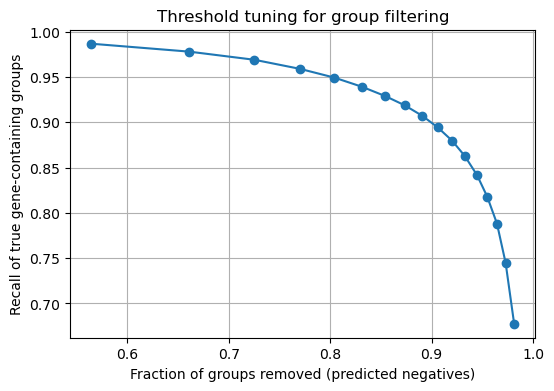

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Compute predicted probabilities
# -----------------------------
features_comp = best_lgb_comp.feature_name_  # your final feature set
group_df['pred_prob'] = best_lgb_comp.predict_proba(group_df[features_comp])[:, 1]

# -----------------------------
# 2️⃣ Test thresholds
# -----------------------------
thresholds = np.arange(0.1, 0.95, 0.05)
results = []

for t in thresholds:
    pred_label = (group_df['pred_prob'] >= t).astype(int)
    
    # Recall on true-positive groups
    tp_groups = group_df[group_df['label'] == 1]
    recall = (pred_label[tp_groups.index] == 1).sum() / len(tp_groups)
    
    # Fraction of negative groups removed
    neg_groups = group_df[group_df['label'] == 0]
    removed_frac = 1 - (pred_label[neg_groups.index] == 1).sum() / len(neg_groups)
    
    results.append({"threshold": t, "recall": recall, "removed_frac": removed_frac})

results_df = pd.DataFrame(results)

# -----------------------------
# 3️⃣ Find candidate threshold(s)
# -----------------------------
# Example: keep at least 98% recall
candidate = results_df[results_df['recall'] >= 0.98].sort_values('removed_frac', ascending=False).head(1)
print("Recommended threshold(s) with >=98% recall:")
print(candidate)

# -----------------------------
# 4️⃣ Visualize tradeoff
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(results_df['removed_frac'], results_df['recall'], marker='o')
plt.xlabel("Fraction of groups removed (predicted negatives)")
plt.ylabel("Recall of true gene-containing groups")
plt.title("Threshold tuning for group filtering")
plt.grid(True)
plt.show()


In [14]:

def group_nested_orfs(genome_id: str, cached_data: Dict) -> Dict:
    """Process a single genome through the complete ORF prediction pipeline."""
    print(f"\n{'='*80}")
    print(f"PROCESSING GENOME: {genome_id}")
    print(f"{'='*80}")
    
    # Load ORFs
    genome_data = cached_data[genome_id]
    all_orfs = genome_data['orfs']
    print(f"Total ORFs detected: {len(all_orfs):,}")
    
    # Create training sets
    print(f"\n{'='*80}")
    print("STEP 1: CREATE TRAINING SETS")
    print(f"{'='*80}")
    training_set = create_training_set(genome_id, cached_data)
    intergenic_set = create_intergenic_set(genome_id, cached_data)
    print(f"Training set: {len(training_set):,} ORFs")
    print(f"Intergenic set: {len(intergenic_set):,} regions")
    
    # Build models
    print(f"\n{'='*80}")
    print("STEP 2: BUILD SCORING MODELS")
    print(f"{'='*80}")
    models = build_all_scoring_models(training_set, intergenic_set)
    
    # Score ORFs
    print(f"\n{'='*80}")
    print("STEP 3: SCORE ALL ORFs")
    print(f"{'='*80}")
    scored_orfs = score_all_orfs(all_orfs, models)
    
    # Filter candidates
    print(f"\n{'='*80}")
    print("STEP 4: FILTER CANDIDATES (INITIAL)")
    print(f"{'='*80}")
    candidates = filter_candidates(scored_orfs, **FIRST_FILTER_THRESHOLD)
    print(f"Candidates after initial filter: {len(candidates):,}")
    
    # Group ORFs
    print(f"\n{'='*80}")
    print("STEP 5: GROUP NESTED ORFs")
    print(f"{'='*80}")
    grouped_orfs = organize_nested_orfs(candidates)
    print(f"Total groups: {len(grouped_orfs):,}")
    return candidates,grouped_orfs




In [ ]:
results_no_ml = []
results_ml = []
cache= load_cache()

threshold = 0.1

for genome_id in TEST_GENOMES:
    print(f"\n=== Processing {genome_id} ===")
    candidates, grouped_orfs = group_nested_orfs(genome_id, cache)

    group_df_new = prepare_unlabeled_group_features(
        grouped_orfs,
        genome_id,
        START_SELECTION_WEIGHTS
    )

    available_features = [f for f in best_lgb_comp.feature_name_ if f in group_df_new.columns]
    X_new = group_df_new[available_features]
    group_df_new["pred_comp"] = best_lgb_comp.predict_proba(X_new)[:, 1]

    # --- Identify which groups to keep ---
    kept_group_ids = set(
        group_df_new.loc[group_df_new["pred_comp"] >= threshold, "group_id"]
    )

    # --- Filter grouped_orfs (keeping same structure) ---
    filtered_grouped_orfs = {
        gid: orfs for gid, orfs in grouped_orfs.items() if gid in kept_group_ids
    }

    print(
        f"Kept {len(filtered_grouped_orfs)} / {len(grouped_orfs)} groups "
        f"({len(grouped_orfs) - len(filtered_grouped_orfs)} removed)"
    )

    # --- Select ORFs ---
    selected_orfs = select_best_starts(grouped_orfs)
    selected_orfs_ML = select_best_starts(filtered_grouped_orfs)

    # --- Compare both methods ---
    res_no_ml = compare_orfs_to_reference(selected_orfs, genome_id, cache)
    res_ml = compare_orfs_to_reference(selected_orfs_ML, genome_id, cache)

    results_no_ml.append(res_no_ml)
    results_ml.append(res_ml)

# --- Average metrics across all genomes ---
def avg_results(results):
    keys = results[0].keys()
    return {k: sum(r[k] for r in results) / len(results) for k in keys if isinstance(results[0][k], (int, float))}

avg_no_ml = avg_results(results_no_ml)
avg_ml = avg_results(results_ml)

print("\n=== AVERAGED RESULTS ACROSS TEST GENOMES ===")
print("Without ML filter:")
for k, v in avg_no_ml.items():
    print(f"  {k}: {v:.3f}")

print("\nWith ML filter:")
for k, v in avg_ml.items():
    print(f"  {k}: {v:.3f}")


Loading cached data from C:\Users\User\Desktop\Bacterial Gene Prediction & Comparison Project\data\processed\cached_orfs.pkl...
Loaded 15 cached genomes

=== Processing NC_000913.3 ===

PROCESSING GENOME: NC_000913.3
Total ORFs detected: 176,315

STEP 1: CREATE TRAINING SETS
Training set: 1,220 ORFs
Intergenic set: 490 regions

STEP 2: BUILD SCORING MODELS
Building traditional scoring models...
  Building codon usage models...
  Building IMM models...
✓ All models built in 2.7s
  IMM order: 6
  Training sequences: 1220 (1,809,003 bp)
  Intergenic sequences: 490 (148,082 bp)

STEP 3: SCORE ALL ORFs
Scoring 176,315 ORFs with traditional methods...
  25,000...
  50,000...
  75,000...
  100,000...
  125,000...
  150,000...
  175,000...
✓ Scoring complete in 1.5 minutes

Normalizing 176,315 ORF scores...
✓ Normalization complete

Calculating combined scores...
Combined scores added

STEP 4: FILTER CANDIDATES (INITIAL)
Filtered: 75,828 kept, 100,487 removed
Candidates after initial filter: 7

Groups NC_000913.3: 100%|██████████| 6977/6977 [00:02<00:00, 3274.57it/s]


Kept 5179 / 6977 groups (1798 removed)

Selecting best start for 6,977 groups
  Single option groups: 1,729
  Multiple option groups: 5,248
  Selection breakdown:
    rbs_winner: 1,092
    imm_winner: 292
    codon_winner: 747
    length_winner: 3,117

Selecting best start for 5,179 groups
  Single option groups: 497
  Multiple option groups: 4,682
  Selection breakdown:
    rbs_winner: 858
    imm_winner: 270
    codon_winner: 663
    length_winner: 2,891
VALIDATION SUMMARY: NC_000913.3
Predicted ORFs:              6,977
Reference CDS (proteins):    4,340
True positives (exact):      3,591
False negatives (missed):    749
False positives (spurious):  3,386

Sensitivity (Recall):        82.74%
Precision:                   51.47%
F1 Score:                    63.46
VALIDATION SUMMARY: NC_000913.3
Predicted ORFs:              5,179
Reference CDS (proteins):    4,340
True positives (exact):      3,547
False negatives (missed):    793
False positives (spurious):  1,632

Sensitivity (Recall)

Groups NC_000964.3: 100%|██████████| 5356/5356 [00:00<00:00, 9263.44it/s]


Kept 4163 / 5356 groups (1193 removed)

Selecting best start for 5,356 groups
  Single option groups: 1,124
  Multiple option groups: 4,232
  Selection breakdown:
    rbs_winner: 1,283
    imm_winner: 338
    codon_winner: 626
    length_winner: 1,985

Selecting best start for 4,163 groups
  Single option groups: 303
  Multiple option groups: 3,860
  Selection breakdown:
    rbs_winner: 1,094
    imm_winner: 300
    codon_winner: 606
    length_winner: 1,860
VALIDATION SUMMARY: NC_000964.3
Predicted ORFs:              5,356
Reference CDS (proteins):    4,240
True positives (exact):      3,207
False negatives (missed):    1,033
False positives (spurious):  2,149

Sensitivity (Recall):        75.64%
Precision:                   59.88%
F1 Score:                    66.84
VALIDATION SUMMARY: NC_000964.3
Predicted ORFs:              4,163
Reference CDS (proteins):    4,240
True positives (exact):      3,176
False negatives (missed):    1,064
False positives (spurious):  987

Sensitivity (Rec

Groups NC_003197.2: 100%|██████████| 7337/7337 [00:02<00:00, 3388.79it/s]


Kept 5375 / 7337 groups (1962 removed)

Selecting best start for 7,337 groups
  Single option groups: 1,863
  Multiple option groups: 5,474
  Selection breakdown:
    rbs_winner: 1,259
    imm_winner: 222
    codon_winner: 847
    length_winner: 3,146

Selecting best start for 5,375 groups
  Single option groups: 534
  Multiple option groups: 4,841
  Selection breakdown:
    rbs_winner: 1,014
    imm_winner: 187
    codon_winner: 734
    length_winner: 2,906
VALIDATION SUMMARY: NC_003197.2
Predicted ORFs:              7,337
Reference CDS (proteins):    4,453
True positives (exact):      3,604
False negatives (missed):    849
False positives (spurious):  3,733

Sensitivity (Recall):        80.93%
Precision:                   49.12%
F1 Score:                    61.14
VALIDATION SUMMARY: NC_003197.2
Predicted ORFs:              5,375
Reference CDS (proteins):    4,453
True positives (exact):      3,531
False negatives (missed):    922
False positives (spurious):  1,844

Sensitivity (Recal

Groups NC_002505.1: 100%|██████████| 3358/3358 [00:01<00:00, 2906.65it/s]


Kept 2631 / 3358 groups (727 removed)

Selecting best start for 3,358 groups
  Single option groups: 671
  Multiple option groups: 2,687
  Selection breakdown:
    rbs_winner: 572
    imm_winner: 241
    codon_winner: 323
    length_winner: 1,551

Selecting best start for 2,631 groups
  Single option groups: 165
  Multiple option groups: 2,466
  Selection breakdown:
    rbs_winner: 448
    imm_winner: 229
    codon_winner: 303
    length_winner: 1,486
VALIDATION SUMMARY: NC_002505.1
Predicted ORFs:              3,358
Reference CDS (proteins):    2,578
True positives (exact):      2,186
False negatives (missed):    392
False positives (spurious):  1,172

Sensitivity (Recall):        84.79%
Precision:                   65.10%
F1 Score:                    73.65
VALIDATION SUMMARY: NC_002505.1
Predicted ORFs:              2,631
Reference CDS (proteins):    2,578
True positives (exact):      2,159
False negatives (missed):    419
False positives (spurious):  472

Sensitivity (Recall):      

Groups NC_000962.3: 100%|██████████| 10874/10874 [00:03<00:00, 3171.90it/s]


Kept 6761 / 10874 groups (4113 removed)

Selecting best start for 10,874 groups
  Single option groups: 3,035
  Multiple option groups: 7,839
  Selection breakdown:
    rbs_winner: 1,831
    imm_winner: 1,130
    codon_winner: 990
    length_winner: 3,888

Selecting best start for 6,761 groups
  Single option groups: 670
  Multiple option groups: 6,091
  Selection breakdown:
    rbs_winner: 1,141
    imm_winner: 910
    codon_winner: 810
    length_winner: 3,230
VALIDATION SUMMARY: NC_000962.3
Predicted ORFs:              10,874
Reference CDS (proteins):    3,906
True positives (exact):      2,669
False negatives (missed):    1,237
False positives (spurious):  8,205

Sensitivity (Recall):        68.33%
Precision:                   24.54%
F1 Score:                    36.12
VALIDATION SUMMARY: NC_000962.3
Predicted ORFs:              6,761
Reference CDS (proteins):    3,906
True positives (exact):      2,578
False negatives (missed):    1,328
False positives (spurious):  4,183

Sensitivi

Groups NC_002695.2: 100%|██████████| 8362/8362 [00:02<00:00, 3107.33it/s]


Kept 6312 / 8362 groups (2050 removed)

Selecting best start for 8,362 groups
  Single option groups: 2,143
  Multiple option groups: 6,219
  Selection breakdown:
    rbs_winner: 1,371
    imm_winner: 232
    codon_winner: 1,126
    length_winner: 3,490

Selecting best start for 6,312 groups
  Single option groups: 734
  Multiple option groups: 5,578
  Selection breakdown:
    rbs_winner: 1,116
    imm_winner: 208
    codon_winner: 1,007
    length_winner: 3,247
VALIDATION SUMMARY: NC_002695.2
Predicted ORFs:              8,362
Reference CDS (proteins):    5,068
True positives (exact):      4,277
False negatives (missed):    791
False positives (spurious):  4,085

Sensitivity (Recall):        84.39%
Precision:                   51.15%
F1 Score:                    63.69
VALIDATION SUMMARY: NC_002695.2
Predicted ORFs:              6,312
Reference CDS (proteins):    5,068
True positives (exact):      4,193
False negatives (missed):    875
False positives (spurious):  2,119

Sensitivity (R

Groups NC_008253.1: 100%|██████████| 7237/7237 [00:02<00:00, 3139.85it/s]


Kept 5471 / 7237 groups (1766 removed)

Selecting best start for 7,237 groups
  Single option groups: 1,842
  Multiple option groups: 5,395
  Selection breakdown:
    rbs_winner: 1,169
    imm_winner: 228
    codon_winner: 924
    length_winner: 3,074

Selecting best start for 5,471 groups
  Single option groups: 589
  Multiple option groups: 4,882
  Selection breakdown:
    rbs_winner: 974
    imm_winner: 216
    codon_winner: 824
    length_winner: 2,868
VALIDATION SUMMARY: NC_008253.1
Predicted ORFs:              7,237
Reference CDS (proteins):    4,620
True positives (exact):      3,695
False negatives (missed):    925
False positives (spurious):  3,542

Sensitivity (Recall):        79.98%
Precision:                   51.06%
F1 Score:                    62.33
VALIDATION SUMMARY: NC_008253.1
Predicted ORFs:              5,471
Reference CDS (proteins):    4,620
True positives (exact):      3,656
False negatives (missed):    964
False positives (spurious):  1,815

Sensitivity (Recall)

Groups NC_000915.1: 100%|██████████| 1654/1654 [00:00<00:00, 2922.65it/s]


Kept 1423 / 1654 groups (231 removed)

Selecting best start for 1,654 groups
  Single option groups: 193
  Multiple option groups: 1,461
  Selection breakdown:
    rbs_winner: 366
    imm_winner: 122
    codon_winner: 175
    length_winner: 798

Selecting best start for 1,423 groups
  Single option groups: 66
  Multiple option groups: 1,357
  Selection breakdown:
    rbs_winner: 309
    imm_winner: 109
    codon_winner: 166
    length_winner: 773
VALIDATION SUMMARY: NC_000915.1
Predicted ORFs:              1,654
Reference CDS (proteins):    1,558
True positives (exact):      1,187
False negatives (missed):    371
False positives (spurious):  467

Sensitivity (Recall):        76.19%
Precision:                   71.77%
F1 Score:                    73.91
VALIDATION SUMMARY: NC_000915.1
Predicted ORFs:              1,423
Reference CDS (proteins):    1,558
True positives (exact):      1,139
False negatives (missed):    419
False positives (spurious):  284

Sensitivity (Recall):        73.11

Groups NC_003210.1: 100%|██████████| 3110/3110 [00:01<00:00, 2937.97it/s]


Kept 2815 / 3110 groups (295 removed)

Selecting best start for 3,110 groups
  Single option groups: 409
  Multiple option groups: 2,701
  Selection breakdown:
    rbs_winner: 946
    imm_winner: 154
    codon_winner: 298
    length_winner: 1,303

Selecting best start for 2,815 groups
  Single option groups: 185
  Multiple option groups: 2,630
  Selection breakdown:
    rbs_winner: 909
    imm_winner: 147
    codon_winner: 292
    length_winner: 1,282
VALIDATION SUMMARY: NC_003210.1
Predicted ORFs:              3,110
Reference CDS (proteins):    2,867
True positives (exact):      2,488
False negatives (missed):    379
False positives (spurious):  622

Sensitivity (Recall):        86.78%
Precision:                   80.00%
F1 Score:                    83.25
VALIDATION SUMMARY: NC_003210.1
Predicted ORFs:              2,815
Reference CDS (proteins):    2,867
True positives (exact):      2,475
False negatives (missed):    392
False positives (spurious):  340

Sensitivity (Recall):        

Groups NC_002516.2: 100%|██████████| 14482/14482 [00:01<00:00, 9604.28it/s]


Kept 7842 / 14482 groups (6640 removed)

Selecting best start for 14,482 groups
  Single option groups: 3,093
  Multiple option groups: 11,389
  Selection breakdown:
    rbs_winner: 2,158
    imm_winner: 1,370
    codon_winner: 1,669
    length_winner: 6,192

Selecting best start for 7,842 groups
  Single option groups: 321
  Multiple option groups: 7,521
  Selection breakdown:
    rbs_winner: 1,194
    imm_winner: 1,214
    codon_winner: 1,516
    length_winner: 3,597
VALIDATION SUMMARY: NC_002516.2
Predicted ORFs:              14,482
Reference CDS (proteins):    5,573
True positives (exact):      4,590
False negatives (missed):    983
False positives (spurious):  9,892

Sensitivity (Recall):        82.36%
Precision:                   31.69%
F1 Score:                    45.77
VALIDATION SUMMARY: NC_002516.2
Predicted ORFs:              7,842
Reference CDS (proteins):    5,573
True positives (exact):      4,505
False negatives (missed):    1,068
False positives (spurious):  3,337

Sens

Groups NC_000854.2: 100%|██████████| 2372/2372 [00:00<00:00, 9415.37it/s]


Kept 1768 / 2372 groups (604 removed)

Selecting best start for 2,372 groups
  Single option groups: 504
  Multiple option groups: 1,868
  Selection breakdown:
    rbs_winner: 243
    imm_winner: 270
    codon_winner: 303
    length_winner: 1,052

Selecting best start for 1,768 groups
  Single option groups: 128
  Multiple option groups: 1,640
  Selection breakdown:
    rbs_winner: 172
    imm_winner: 236
    codon_winner: 288
    length_winner: 944
VALIDATION SUMMARY: NC_000854.2
Predicted ORFs:              2,372
Reference CDS (proteins):    1,712
True positives (exact):      920
False negatives (missed):    792
False positives (spurious):  1,452

Sensitivity (Recall):        53.74%
Precision:                   38.79%
F1 Score:                    45.05
VALIDATION SUMMARY: NC_000854.2
Predicted ORFs:              1,768
Reference CDS (proteins):    1,712
True positives (exact):      869
False negatives (missed):    843
False positives (spurious):  899

Sensitivity (Recall):        50.7

Groups NC_000868.1: 100%|██████████| 2086/2086 [00:00<00:00, 9607.70it/s]


Kept 1833 / 2086 groups (253 removed)

Selecting best start for 2,086 groups
  Single option groups: 270
  Multiple option groups: 1,816
  Selection breakdown:
    rbs_winner: 302
    imm_winner: 181
    codon_winner: 288
    length_winner: 1,045

Selecting best start for 1,833 groups
  Single option groups: 105
  Multiple option groups: 1,728
  Selection breakdown:
    rbs_winner: 257
    imm_winner: 173
    codon_winner: 285
    length_winner: 1,013
VALIDATION SUMMARY: NC_000868.1
Predicted ORFs:              2,086
Reference CDS (proteins):    1,917
True positives (exact):      1,548
False negatives (missed):    369
False positives (spurious):  538

Sensitivity (Recall):        80.75%
Precision:                   74.21%
F1 Score:                    77.34
VALIDATION SUMMARY: NC_000868.1
Predicted ORFs:              1,833
Reference CDS (proteins):    1,917
True positives (exact):      1,508
False negatives (missed):    409
False positives (spurious):  325

Sensitivity (Recall):        

Groups NC_002607.1: 100%|██████████| 5318/5318 [00:00<00:00, 9777.22it/s] 


Kept 3097 / 5318 groups (2221 removed)

Selecting best start for 5,318 groups
  Single option groups: 1,107
  Multiple option groups: 4,211
  Selection breakdown:
    rbs_winner: 677
    imm_winner: 643
    codon_winner: 562
    length_winner: 2,329

Selecting best start for 3,097 groups
  Single option groups: 204
  Multiple option groups: 2,893
  Selection breakdown:
    rbs_winner: 348
    imm_winner: 576
    codon_winner: 497
    length_winner: 1,472
VALIDATION SUMMARY: NC_002607.1
Predicted ORFs:              5,318
Reference CDS (proteins):    2,128
True positives (exact):      1,428
False negatives (missed):    700
False positives (spurious):  3,890

Sensitivity (Recall):        67.11%
Precision:                   26.85%
F1 Score:                    38.36
VALIDATION SUMMARY: NC_002607.1
Predicted ORFs:              3,097
Reference CDS (proteins):    2,128
True positives (exact):      1,376
False negatives (missed):    752
False positives (spurious):  1,721

Sensitivity (Recall): 

Groups NC_003552.1: 100%|██████████| 8166/8166 [00:02<00:00, 3636.06it/s]


Kept 6644 / 8166 groups (1522 removed)

Selecting best start for 8,166 groups
  Single option groups: 2,557
  Multiple option groups: 5,609
  Selection breakdown:
    rbs_winner: 897
    imm_winner: 233
    codon_winner: 1,502
    length_winner: 2,977

Selecting best start for 6,644 groups
  Single option groups: 1,320
  Multiple option groups: 5,324
  Selection breakdown:
    rbs_winner: 817
    imm_winner: 221
    codon_winner: 1,402
    length_winner: 2,884
VALIDATION SUMMARY: NC_003552.1
Predicted ORFs:              8,166
Reference CDS (proteins):    4,884
True positives (exact):      3,265
False negatives (missed):    1,619
False positives (spurious):  4,901

Sensitivity (Recall):        66.85%
Precision:                   39.98%
F1 Score:                    50.04
VALIDATION SUMMARY: NC_003552.1
Predicted ORFs:              6,644
Reference CDS (proteins):    4,884
True positives (exact):      3,206
False negatives (missed):    1,678
False positives (spurious):  3,438

Sensitivity 

Groups NC_000917.1: 100%|██████████| 3412/3412 [00:00<00:00, 3443.85it/s]


Kept 2604 / 3412 groups (808 removed)

Selecting best start for 3,412 groups
  Single option groups: 797
  Multiple option groups: 2,615
  Selection breakdown:
    rbs_winner: 313
    imm_winner: 275
    codon_winner: 419
    length_winner: 1,608

Selecting best start for 2,604 groups
  Single option groups: 242
  Multiple option groups: 2,362
  Selection breakdown:
    rbs_winner: 230
    imm_winner: 253
    codon_winner: 407
    length_winner: 1,472
VALIDATION SUMMARY: NC_000917.1
Predicted ORFs:              3,412
Reference CDS (proteins):    2,515
True positives (exact):      1,785
False negatives (missed):    730
False positives (spurious):  1,627

Sensitivity (Recall):        70.97%
Precision:                   52.32%
F1 Score:                    60.23
VALIDATION SUMMARY: NC_000917.1
Predicted ORFs:              2,604
Reference CDS (proteins):    2,515
True positives (exact):      1,734
False negatives (missed):    781
False positives (spurious):  870

Sensitivity (Recall):      

In [15]:
# ============================================================================
# SAVE THE TRAINED MODEL
# ============================================================================
import joblib
import os

# Create models directory
os.makedirs('../models', exist_ok=True)

# Save the LightGBM classifier
model_path = '../models/orf_classifier_lgb.pkl'
joblib.dump(best_lgb_comp, model_path)
print(f"✓ Saved model: {model_path}")

# Save feature names (CRITICAL!)
feature_path = '../models/feature_names.pkl'
joblib.dump(feature_cols, feature_path)
print(f"✓ Saved {len(feature_cols)} feature names")

# Test loading
loaded_model = joblib.load(model_path)
print(f"✓ Model loads successfully!")
print(f"\n✓✓ MODEL READY FOR DEPLOYMENT! ✓✓")

✓ Saved model: ../models/orf_classifier_lgb.pkl
✓ Saved 31 feature names
✓ Model loads successfully!

✓✓ MODEL READY FOR DEPLOYMENT! ✓✓
